# Prediction of The Types Tumor Cells

### Import Packages

In [1]:
#Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Packages for data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV

#Packages for model development
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Packages for accuracy test
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#Others
import itertools
import pylab as pl
import scipy.optimize as opt

### Load Data

In [2]:
data = pd.read_csv(r'C:\Users\User\Desktop\Data science\3. Machine learning\Machine Learning A-Z (Codes and Datasets)\Data.csv')
data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
print('Number of rows', data.shape[0])
print('Number of cols', data.shape[1])

Number of rows 683
Number of cols 11


In [4]:
#Descrptive of the data
data.drop('Sample code number', axis = 1).describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


### Checking missing values

There is no missing values in any columns

In [5]:
data.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

### Exploring the distribution

The following distrbutions have been separated by the types of tumor celss. the distrutions reflect that the lower the amount of clump thickness, Uniformity of Cell Size, Uniformity of Cell Shape, and others elements exist, the likelihood of being the tumor cells is Benign is higher. On the contrary, the higher the amount of clump thickness, Uniformity of Cell Size, Uniformity of Cell Shape, and others elements exist, the likelihood of being the tumor cells is Malignant is higher.

<AxesSubplot:xlabel='Mitoses', ylabel='Count'>

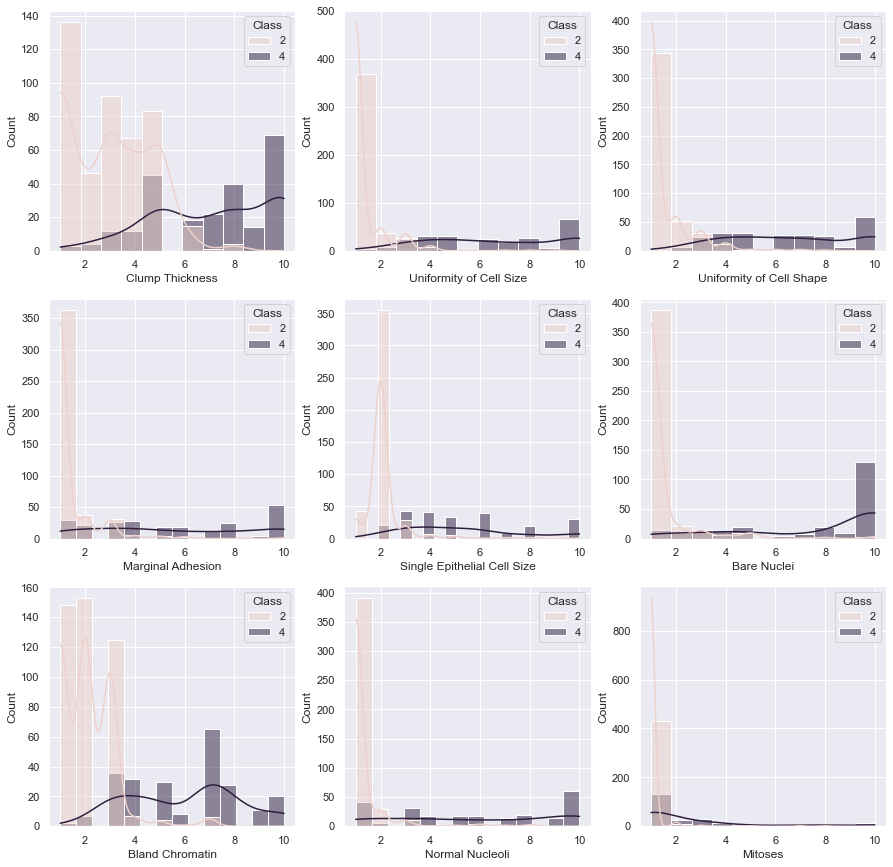

In [6]:
fig, axes = plt.subplots(3, 3, sharey = False, figsize = (15, 15))

sns.histplot(ax = axes[0,0], x = data['Clump Thickness'], hue = data['Class'], kde = True)
sns.histplot(ax = axes[0,1], x = data['Uniformity of Cell Size'], hue = data['Class'], kde = True)
sns.histplot(ax = axes[0,2], x = data['Uniformity of Cell Shape'], hue = data['Class'], kde = True)

sns.histplot(ax = axes[1,0], x = data['Marginal Adhesion'], hue = data['Class'], kde = True)
sns.histplot(ax = axes[1,1], x = data['Single Epithelial Cell Size'], hue = data['Class'], kde = True)
sns.histplot(ax = axes[1,2], x = data['Bare Nuclei'], hue = data['Class'], kde = True)

sns.histplot(ax = axes[2,0], x = data['Bland Chromatin'], hue = data['Class'], kde = True)
sns.histplot(ax = axes[2,1], x = data['Normal Nucleoli'], hue = data['Class'], kde = True)
sns.histplot(ax = axes[2,2], x = data['Mitoses'], hue = data['Class'], kde = True)

### Feature selection

In [7]:
#Selecting target
y = data['Class']

#Select features
x = data.drop('Class', axis = 1)

In [8]:
#checking features with zero variance
var_thres = VarianceThreshold(threshold = 0)
var_thres.fit(x)

#Number of zero constant features
cons_cols = [column for column in x.columns
            if column not in x.columns[var_thres.get_support()]]
print('Number of columns:', len(cons_cols))

Number of columns: 0


In [9]:
#Function to identify highly correlated features
def corr(data, threshold):
    cols_corr = set()
    corr_mat = x.corr()
    for i in range(len(x.columns)):
        for j in range(i):
            if abs(corr_mat.iloc[i, j] > threshold):
                cols_corr.add(corr_mat.columns[i])
    return cols_corr

correlated_fetures = corr(x, 0.8) 
print('Number of highly correlated features:', len(set(correlated_fetures)))
print(correlated_fetures)

Number of highly correlated features: 1
{'Uniformity of Cell Shape'}


<AxesSubplot:>

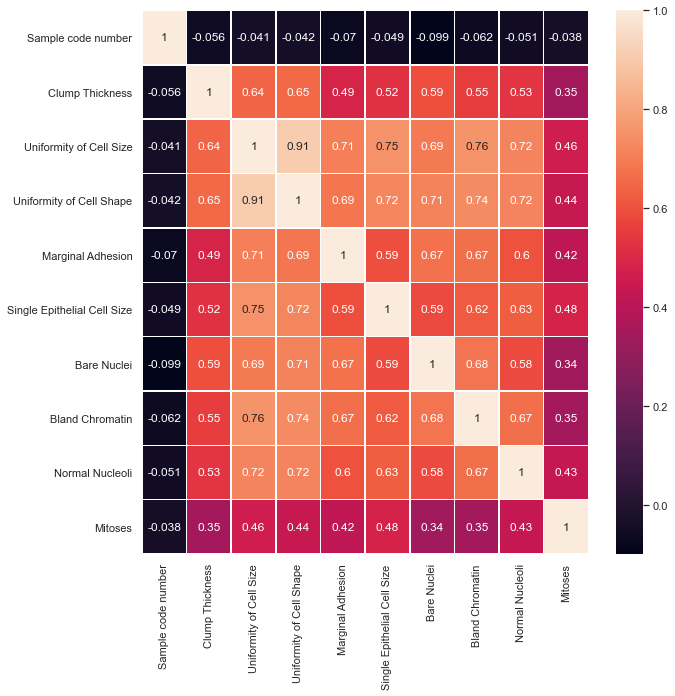

In [10]:
#Visualizing the correlations
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(x.corr(), annot = True, linewidths = 0.5, ax = ax)

In [11]:
#Dropping  highly correlated features
x = x.drop(correlated_fetures, axis = 1)
x.shape

(683, 9)

In [12]:
#Deriving the information gain of the features
mutual_info = mutual_info_regression(x, y)
mutual_info = pd.DataFrame(mutual_info, columns = ['IG_values'])
mutual_info['Features'] = x.columns
mutual_info = mutual_info.sort_values('IG_values')
mutual_info

,IG_values,Features
0,0.000000,Sample code number
8,0.143890,Mitoses
7,0.215914,Normal Nucleoli
1,0.271109,Clump Thickness
3,0.306599,Marginal Adhesion
4,0.327303,Single Epithelial Cell Size
6,0.329665,Bland Chromatin
5,0.407727,Bare Nuclei
2,0.413912,Uniformity of Cell Size


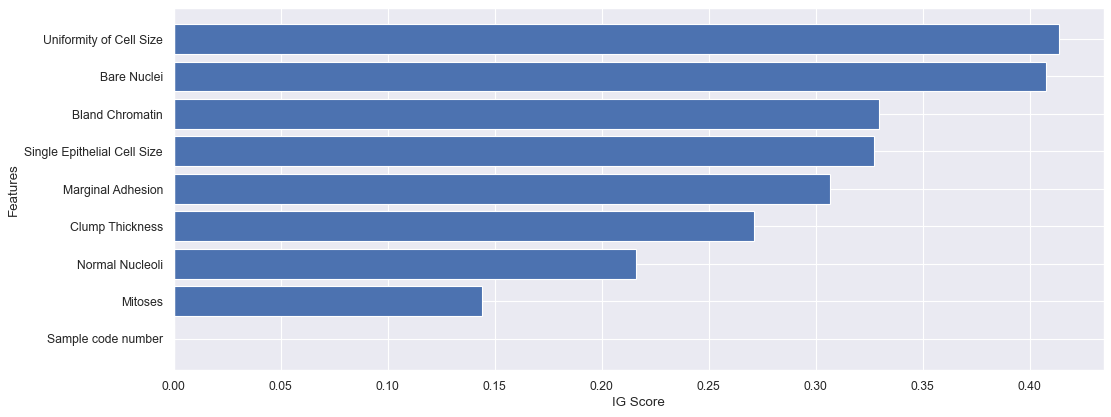

In [13]:
#Plotting the features with IG values
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(mutual_info['Features'], mutual_info['IG_values'], align = 'center')
plt.ylabel('Features')
plt.xlabel('IG Score')
plt.show()

In [14]:
#Dropping features with lowest information gain
x = x.drop('Sample code number', axis = 1)
x = np.asarray(x)
y = np.asarray(y)

### Preprocessing

In [15]:
#Scaling data to reduce the magnitude of the difference
x_scaled = preprocessing.scale(x)
x_scaled

array([[ 0.19790469, -0.70221201, -0.63936553, ..., -0.18182716,
        -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.75803177, ..., -0.18182716,
        -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.63936553, ..., -0.18182716,
        -0.61292736, -0.34839971],
       ...,
       [ 0.19790469,  2.23617957,  0.05933312, ...,  1.86073779,
         2.33747554,  0.22916583],
       [-0.15686934,  1.58320366,  0.40868245, ...,  2.67776377,
         1.02618536, -0.34839971],
       [-0.15686934,  1.58320366,  0.75803177, ...,  2.67776377,
         0.37054027, -0.34839971]])

In [16]:
#Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 42)
print('Number of rows of train data', x_train.shape[0])
print('Number of rows of test data', x_test.shape[0])

Number of rows of train data 546
Number of rows of test data 137


### Logistic Regression

In [17]:
#Model building
lr = LogisticRegression(C=0.01, solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [18]:
#Predicting test data
lyhat = lr.predict(x_test)
lyhat

array([4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 4, 2,
       4, 2, 2, 2, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 2, 4, 4, 2, 4, 4, 2,
       2, 4, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 4, 2, 2,
       4, 4, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 4, 4, 4, 4, 2, 4, 2, 4, 2, 2,
       4, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2,
       4, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2,
       4, 4, 4, 2, 2], dtype=int64)

In [19]:
#Function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print(confusion_matrix(y_test, lyhat, labels=[2,4]))

[[78  1]
 [ 3 55]]


In [20]:
#confusion matrix
cnf_matrix = confusion_matrix(y_test, lyhat, labels=[2, 4])
np.set_printoptions(precision=2)

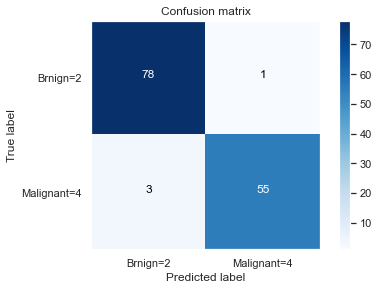

In [21]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Brnign=2','Malignant=4'],normalize=
False, title='Confusion matrix')
plt.grid(False)

In [22]:
#Show classification report
print (classification_report(y_test, lyhat))

              precision    recall  f1-score   support

           2       0.96      0.99      0.97        79
           4       0.98      0.95      0.96        58

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137



In [23]:
#Cross validation score
score = cross_val_score(lr, x, y, cv = 10)
print('Mean score:', np.mean(score).round(2))
print('std deviation:', np.std(score).round(2))

Mean score: 0.92
std deviation: 0.06


### KNN Classification

[0.96, 0.92, 0.96, 0.95, 0.96, 0.95, 0.96, 0.95, 0.96]


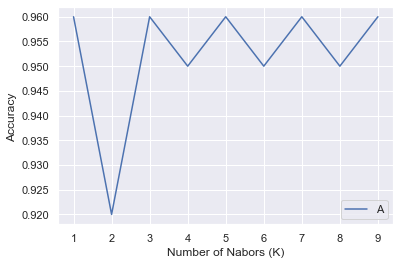

In [24]:
#Determining the correct K
ks = range(1, 10)
acc = []
for i in ks:
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    kyhat = neigh.predict(x_test)
    ac = metrics.accuracy_score(y_test, kyhat).round(2)
    acc.append(ac)
print(acc)

#Plotting K with accuracy
plt.plot(ks,acc)
plt.legend('Accuracy')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.show()

In [25]:
#Model development
k = 3
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [26]:
#Predicting test data
kyhat = neigh.predict(x_test)
kyhat

array([4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 4, 2,
       4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 4, 4, 2, 2, 4, 2, 4, 4, 2, 4, 4, 2,
       2, 4, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 4, 2, 2,
       4, 4, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 4, 4, 4, 4, 2, 4, 2, 4, 2, 2,
       4, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2,
       4, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2,
       4, 4, 4, 2, 2], dtype=int64)

In [27]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_test, kyhat, labels=[2, 4])
print(cnf_matrix)
np.set_printoptions(precision=2)

[[78  1]
 [ 4 54]]


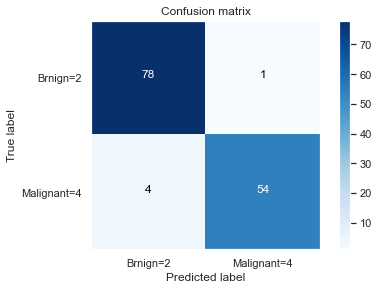

In [28]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Brnign=2','Malignant=4'],normalize=
False, title='Confusion matrix')
plt.grid(False)

In [29]:
#Show classification report
print (classification_report(y_test, kyhat))

              precision    recall  f1-score   support

           2       0.95      0.99      0.97        79
           4       0.98      0.93      0.96        58

    accuracy                           0.96       137
   macro avg       0.97      0.96      0.96       137
weighted avg       0.96      0.96      0.96       137



In [30]:
#Cross validation score
score = cross_val_score(neigh, x, y, cv = 10)
print('Mean score:', np.mean(score).round(2))
print('std deviation:', np.std(score).round(2))

Mean score: 0.96
std deviation: 0.03


### Random Forest Classification

In [31]:
#Model development
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [32]:
#Predicting test data
ryhat = rf.predict(x_test)
ryhat

array([4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 4, 2,
       4, 2, 2, 2, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 2, 4, 4, 2, 4, 4, 2,
       2, 4, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 4, 2, 2,
       4, 4, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 4, 4, 4, 4, 2, 4, 2, 4, 2, 2,
       4, 2, 2, 4, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2,
       4, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
       4, 4, 4, 2, 2], dtype=int64)

In [33]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_test, ryhat, labels=[2, 4])
print(cnf_matrix)
np.set_printoptions(precision=2)

[[78  1]
 [ 2 56]]


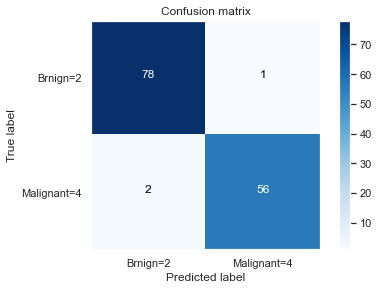

In [34]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Brnign=2','Malignant=4'],normalize=
False, title='Confusion matrix')
plt.grid(False)

In [35]:
#Show classification report
print (classification_report(y_test, ryhat))

              precision    recall  f1-score   support

           2       0.97      0.99      0.98        79
           4       0.98      0.97      0.97        58

    accuracy                           0.98       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.98      0.98      0.98       137



In [36]:
#Cross validation score
score = cross_val_score(rf, x, y, cv = 10)
print('Mean score:', np.mean(score).round(2))
print('std deviation:', np.std(score).round(2))

Mean score: 0.97
std deviation: 0.02


### SVM Classification

In [37]:
#Model development
svm = SVC(kernel='rbf')
svm.fit(x_train, y_train)

SVC()

In [38]:
#Predicting the test data
syhat =svm.predict(x_test)
syhat

array([4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 4, 2,
       4, 2, 2, 2, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 2, 4, 4, 2, 4, 4, 2,
       2, 4, 2, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 4, 2, 2,
       4, 4, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 4, 4, 4, 4, 2, 4, 2, 4, 2, 2,
       4, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 2,
       4, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2,
       4, 4, 4, 2, 2], dtype=int64)

In [39]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_test, syhat, labels=[2, 4])
print(cnf_matrix)
np.set_printoptions(precision=2)

[[77  2]
 [ 3 55]]


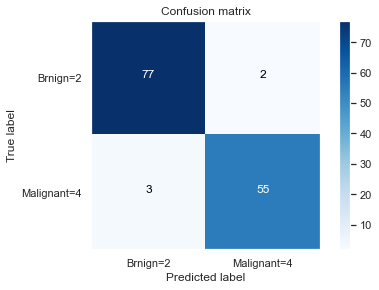

In [40]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Brnign=2','Malignant=4'],normalize=
False, title='Confusion matrix')
plt.grid(False)

In [41]:
#Show classification report
print (classification_report(y_test, syhat))

              precision    recall  f1-score   support

           2       0.96      0.97      0.97        79
           4       0.96      0.95      0.96        58

    accuracy                           0.96       137
   macro avg       0.96      0.96      0.96       137
weighted avg       0.96      0.96      0.96       137



In [42]:
#Cross validation score
score = cross_val_score(svm, x, y, cv = 10)
print('Mean score:', np.mean(score).round(2))
print('std deviation:', np.std(score).round(2))

Mean score: 0.97
std deviation: 0.03


### Extreme Gradient Boosting Classification

In [43]:
#Encoding types of classes to remove the deprecation warning
encoded_y = pd.DataFrame(y, columns = ['Class'])
encoded_y = encoded_y['Class'].map({2: 0, 4: 1})
encoded_y = np.asarray(encoded_y)

encoded_y_train = pd.DataFrame(y_train, columns = ['y_train'])
encoded_y_train = encoded_y_train['y_train'].map({2: 0, 4: 1})
encoded_y_train = np.asarray(encoded_y_train)

encoded_y_test = pd.DataFrame(y_test, columns = ['y_test'])
encoded_y_test = encoded_y_test['y_test'].map({2: 0, 4: 1})
encoded_y_test = np.asarray(encoded_y_test)

In [44]:
#Model development
xcl = XGBClassifier(eval_metric='mlogloss', use_label_encoder = False)
xcl.fit(x_train, encoded_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [45]:
#Predicting the test data
xyhat =xcl.predict(x_test)
xyhat

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0])

In [46]:
# Confusion matrix
cnf_matrix = confusion_matrix(encoded_y_test, xyhat, labels=[0, 1])
print(cnf_matrix)
np.set_printoptions(precision=2)

[[78  1]
 [ 6 52]]


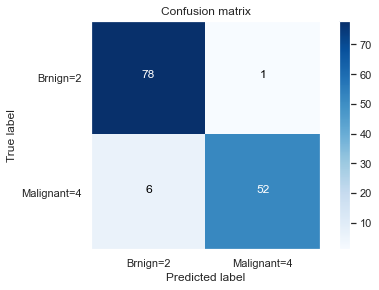

In [47]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Brnign=2','Malignant=4'],normalize=
False, title='Confusion matrix')
plt.grid(False)

In [48]:
#Show classification report
print (classification_report(encoded_y_test, xyhat))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96        79
           1       0.98      0.90      0.94        58

    accuracy                           0.95       137
   macro avg       0.95      0.94      0.95       137
weighted avg       0.95      0.95      0.95       137



In [49]:
#Cross validation score
score = cross_val_score(xcl, x, encoded_y, cv = 10)
print('Mean score:', np.mean(score).round(2))
print('std deviation:', np.std(score).round(2))

Mean score: 0.96
std deviation: 0.03


## Identifying the best Classifier 

In [50]:
#Summary accuracy of the classifiers
accuracy_table = pd.DataFrame({'Model': ['Logistic', 'KNN', 'Random Forest', 'SVM', 'XGBoost'],
                               'Test accuracy': [0.97, 0.96, 0.96, 0.96, 0.95],
                               'Mean CVS': [0.92, 0.96, 0.97, 0.97, 0.96], 
                               'Std. dev. CVS': [0.06, 0.03, 0.02, 0.03, 0.03]})
accuracy_table = accuracy_table.set_index('Model')
accuracy_table

,Test accuracy,Mean CVS,Std. dev. CVS
Model,,,
Logistic,0.97,0.92,0.06
KNN,0.96,0.96,0.03
Random Forest,0.96,0.97,0.02
SVM,0.96,0.97,0.03
XGBoost,0.95,0.96,0.03


Text(0.5, 1.0, 'Accuracy Matrix')

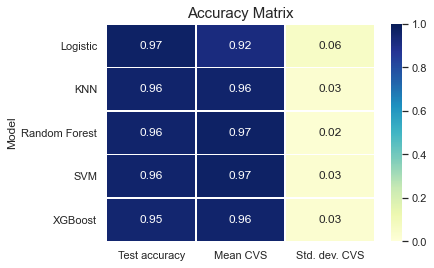

In [51]:
#Plotting accuracies with models
sns.heatmap(accuracy_table, annot = True, vmin = 1, vmax = 0, linewidths = 0.5, cmap = "YlGnBu")
plt.title('Accuracy Matrix', size = 15)

All the model have performed better with a mean cross validation accuracy score more than 90% to estimate the types of tumor cells based on the selected inputs. Comparatively, Logistic regression model has the lower mean cross val score while Random forest and SVM have the higher mean cross val score than others. Considering the variation of the accuracy for defferent dataset, the lowest standard deviation belongs to Random forest model. Thus, **Random Forest Classification model is the most parsimonious model to predict the tumor cells with a mean CVS score of 97% in future**. But, for this particular dataset, logistic regression is providing the highest accuracy score of 97%. 